This notebooks calculates the progression of accuracy as increment length increases.

In [1]:
import pickle
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pl

In [2]:
def load_data(model,mode, dataset, split):
#load predicted and gold bounding boxes

    try:

        #the predicted bounding box
        with open(r"/home/users/fschreiber/project/bboxes_"+model+"/"+dataset+"/"+split+"_pred_bbox_list.p","rb") as f:
            pred_bbox_list=list(pickle.load(f))

        if mode=="non_inc":
            #the target bounding box
            with open(r"/home/users/fschreiber/project/bboxes_noninc_"+model+"/"+dataset+"/"+split+"_pred_bbox_list.p","rb") as f:
                target_bbox_list=list(pickle.load(f))

        elif mode == "inc":
            #the target bounding box
            with open(r"/home/users/fschreiber/project/bboxes_"+model+"/"+dataset+"/"+split+"_target_bbox_list.p","rb") as f:
                target_bbox_list=list(pickle.load(f))
        else:
            print("The mode can only be non_inc or inc")
            return -1,-1,-1,-1,-1

        #the number of one sentence split up incrementally ("the left zebra" would have length 3)
        with open(r"/home/users/fschreiber/project/incremental_pickles/length_incremental_units/"+dataset+"_"+split+"_length_unit.p","rb") as f:
            inc_len=pickle.load(f)

        #the original model data split up incrementally
        data_model=torch.load("/home/users/fschreiber/project/ready_inc_data/"+dataset+"/"+dataset+"_"+split+".pth")

        with open(r"/home/users/fschreiber/project/binary_grouped/"+model+"/"+mode+"/"+dataset+split+".p","rb") as f:
            binary_grouped=pickle.load(f)

        
        if mode=="non_inc":
            target_bbox_list=[x for x,y in zip(target_bbox_list,inc_len) for _ in range(y)]
            
        if model=="TVG":
            pred_bbox_list,target_bbox_list=TVG_prep(pred_bbox_list,target_bbox_list)
                    

        return pred_bbox_list,target_bbox_list,inc_len,data_model,binary_grouped
    
    except FileNotFoundError as e:
        #print(e)
        
        return  -1,-1,-1,-1,-1
    


#TVG needs some extra adjustments to fit the same data format as Resc
def TVG_prep(pred_bbox_list,target_bbox_list):
    #print("TVG")
    for ind,(pred,targ) in enumerate (zip (pred_bbox_list,target_bbox_list)):

        pred=pred.view(1,-1)

        pred=xywh2xyxy(pred)
        pred=torch.clamp(pred,0,1)

        pred_bbox_list[ind]=pred

        targ=targ.view(1,-1)
        targ=xywh2xyxy(targ)

        target_bbox_list[ind]=targ
    return pred_bbox_list,target_bbox_list

#copied from TransVG needed to transform the bounding box vectors
def xywh2xyxy(x):
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=-1)


In [3]:
import torch
import pickle

def load_data(model, mode, dataset, split):
    """
    Load predicted and gold bounding boxes.

    Args:
    model (str): The name of the model.
    mode (str): The mode, either "non_inc" or "inc".
    dataset (str): The dataset name.
    split (str): The data split.

    Returns:
    tuple: A tuple containing the following:
        - pred_bbox_list (list): A list of predicted bounding boxes.
        - target_bbox_list (list): A list of target bounding boxes.
        - inc_len (list): The number of one-sentence units incrementally.
        - data_model (torch.Tensor): The original model data split up incrementally.
        - binary_grouped (list): A binary list of grouped data.

    Note:
    - The mode can only be "non_inc" or "inc."
    - If there are any file not found errors, the function returns placeholders.

    """
    try:
        # Load the predicted bounding box
        with open(r"/home/users/fschreiber/project/bboxes_" + model + "/" + dataset + "/" + split + "_pred_bbox_list.p", "rb") as f:
            pred_bbox_list = list(pickle.load(f))

        if mode == "non_inc":
            # Load the target bounding box for non-incremental mode
            with open(r"/home/users/fschreiber/project/bboxes_noninc_" + model + "/" + dataset + "/" + split + "_pred_bbox_list.p", "rb") as f:
                target_bbox_list = list(pickle.load(f))
        elif mode == "inc":
            # Load the target bounding box for incremental mode
            with open(r"/home/users/fschreiber/project/bboxes_" + model + "/" + dataset + "/" + split + "_target_bbox_list.p", "rb") as f:
                target_bbox_list = list(pickle.load(f))
        else:
            print("The mode can only be non_inc or inc")
            return -1, -1, -1, -1, -1

        # Load the number of one-sentence split up incrementally
        with open(r"/home/users/fschreiber/project/incremental_pickles/length_incremental_units/" + dataset + "_" + split + "_length_unit.p", "rb") as f:
            inc_len = pickle.load(f)

        # Load the original model data split up incrementally
        data_model = torch.load("/home/users/fschreiber/project/ready_inc_data/" + dataset + "/" + dataset + "_" + split + ".pth")

        # Load binary grouped data
        with open(r"/home/users/fschreiber/project/binary_grouped/" + model + "/" + mode + "/" + dataset + split + ".p", "rb") as f:
            binary_grouped = pickle.load(f)

        # If in non-incremental mode, repeat target_bbox_list based on inc_len
        if mode == "non_inc":
            target_bbox_list = [x for x, y in zip(target_bbox_list, inc_len) for _ in range(y)]

        # If the model is "TVG," prepare the data format
        if model == "TVG":
            pred_bbox_list, target_bbox_list = TVG_prep(pred_bbox_list, target_bbox_list)

        return pred_bbox_list, target_bbox_list, inc_len, data_model, binary_grouped

    except FileNotFoundError as e:
        
        return -1, -1, -1, -1, -1


# TVG needs some extra adjustments to fit the same data format as Resc
def TVG_prep(pred_bbox_list, target_bbox_list):
    """
    Prepare the data format for TVG model.

    Args:
    pred_bbox_list (list): A list of predicted bounding boxes.
    target_bbox_list (list): A list of target bounding boxes.

    Returns:
    tuple: A tuple containing the following:
        - pred_bbox_list (list): A list of predicted bounding boxes in the TVG format.
        - target_bbox_list (list): A list of target bounding boxes in the TVG format.

    Note:
    - This function transforms the bounding box vectors to TVG format.

    """
    for ind, (pred, targ) in enumerate(zip(pred_bbox_list, target_bbox_list):

        pred = pred.view(1, -1)
        pred = xywh2xyxy(pred)
        pred = torch.clamp(pred, 0, 1)
        pred_bbox_list[ind] = pred

        targ = targ.view(1, -1)
        targ = xywh2xyxy(targ)
        target_bbox_list[ind] = targ

    return pred_bbox_list, target_bbox_list


# Copied from TransVG, needed to transform the bounding box vectors
def xywh2xyxy(x):
    """
    Convert bounding box format from (x_center, y_center, width, height) to (x_min, y_min, x_max, y_max).

    Args:
    x (torch.Tensor): The bounding box in (x_center, y_center, width, height) format.

    Returns:
    torch.Tensor: The bounding box in (x_min, y_min, x_max, y_max) format.

    """
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h), (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=-1)


SyntaxError: invalid syntax (3120821778.py, line 88)

In [ ]:
pred_bbox_list,target_bbox_list,inc_len,model,binary_grouped=load_data("ReSc","inc","unc","testB")


In [ ]:
# Set the mode and model input parameters
mode = "inc"
model_input = "ReSc"

# Define lists for splits and datasets
split_list = ["testB", "testA", "val", "test"]
dataset_list = ["unc", "unc+", "gref_umd", "gref"]

# Initialize lists to store accuracy results
first_acc = []
last_acc = []
accs_all = []

# Loop through each dataset and split
for file in dataset_list:
    for split in split_list:
    
        # Load data
        pred_bbox_list, target_bbox_list, inc_len, model, binary_grouped = load_data(model_input, mode, file, split)

        # If the file is not found, continue to the next iteration
        if pred_bbox_list == -1 or target_bbox_list == -1 or inc_len == -1:
            pass
        
        else:
            # Print the dataset and split for which the data is loaded
            print(file + split)

            # Create a DataFrame from the binary_grouped data
            df_long = pd.DataFrame(binary_grouped)
            
            # Calculate the count of non-null values for each column
            count_series = df_long.count()
            #
            # since sentence length varies find the length of at least half the examples
            index = (count_series < len(binary_grouped) / 2).idxmax()

            # Create a list containing sentences with lengths less than the calculated index
            binary_grouped_short = []
            for sentence in binary_grouped:
                if len(sentence) < (int(index) + 1):
                    binary_grouped_short.append(sentence)

            # Create a DataFrame from the shortened binary_grouped data
            df_short = pd.DataFrame(binary_grouped_short)
            
            # Calculate the mean for each column
            mean_series = df_short.mean()
            
            # Extract accuracies up to the calculated index
            accs = mean_series[:index]
            accs_all.append(accs)


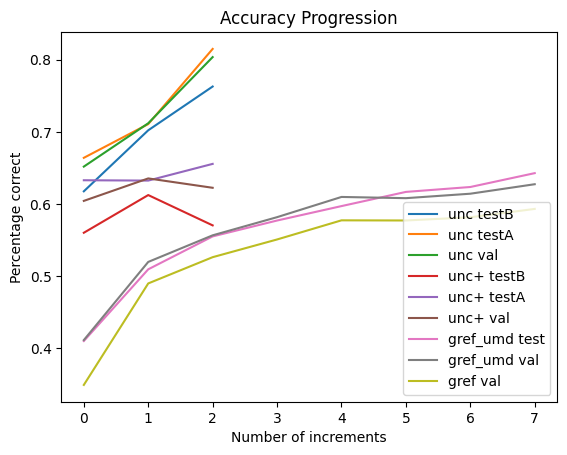

In [ ]:

# List of names corresponding to the series
series_names = ["unc testB","unc testA","unc val","unc+ testB",
                "unc+ testA","unc+ val","gref_umd test","gref_umd val","gref val"]

# Create a Matplotlib figure and axis
fig, ax = plt.subplots()

# Plot each series as a line with corresponding names
for series, name,color in zip(accs_all, series_names,line_colors):
    ax.plot(series, label=name)


# Set labels and legend
ax.set_xlabel("Number of increments")
ax.set_ylabel("Percentage correct")
ax.set_title("Accuracy Progression")
ax.legend()

# Display the plot
plt.show()
